In [1]:
import math
import os
import numpy as np
from tqdm.auto import tqdm
from PIL import Image
import torch
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import DataLoader

from diffusers.optimization import get_scheduler
from google.cloud import storage

from y_sample_dataset3 import SamplingDataset

from model import FontDiffuserModel, FontDiffuserModelDPM, FontDiffuserDPMPipeline
from build import build_unet, build_style_encoder, build_content_encoder, build_ddpm_scheduler
from args import SampleArgs
from utils import x0_from_epsilon, reNormalize_img, normalize_mean_std, save_model, load_model

import unicodedata

def char_normalize(f):
    return unicodedata.normalize('NFC', f)

pygame 2.5.2 (SDL 2.28.2, Python 3.10.14)
Hello from the pygame community. https://www.pygame.org/contribute.html


# To Do list

- 이미지의 마스킹과 시작 노이즈 만드는 부분 제작하기
- 얼마나 커버되는지 확인하기
- 세로모음 가로모임 섞임모음 기준으로 성능 체크하기
- 나머지는 파인튜닝으로 고민해보기

## 글자 형태별 (6가지) 초성중성종성 개별로 inpainting했을때 성능 비교
## 각각 기본 100개 글자만 있을때의 파인튜닝 -> 순차적으로 글자를 더 만들었을때 파인튜닝 성능 확인

In [2]:
fd = "/home/jupyter/ai_font/data/exp0809/inpaint0814"

In [3]:
# for f in os.listdir(fd):
#     nf = char_normalize(f)
#     os.rename(f"{fd}/{f}", f"{fd}/{nf}")

In [4]:
letters = [f.split(".")[0] for f in os.listdir(fd) if ("_m" not in f) & (f.endswith(".png"))]

In [5]:
args = SampleArgs(itern=str(0))
unet = build_unet(args=args)
style_encoder = build_style_encoder(args=args)
content_encoder = build_content_encoder(args=args)
noise_scheduler = build_ddpm_scheduler(args)
storage_client = storage.Client(args.bucket_name)
bucket = storage_client.bucket(args.bucket_name)

itern = 30000
args = SampleArgs(itern=str(itern))
content_encoder.load_state_dict(load_model(bucket, args.content_encoder_path))
style_encoder.load_state_dict(load_model(bucket, args.style_encoder_path))
unet.load_state_dict(load_model(bucket, args.unet_path))

Load the down block  DownBlock2D
Load the down block  MCADownBlock2D
The style_attention cross attention dim in Down Block 1 layer is 1024
The style_attention cross attention dim in Down Block 2 layer is 1024
Load the down block  MCADownBlock2D
The style_attention cross attention dim in Down Block 1 layer is 1024
The style_attention cross attention dim in Down Block 2 layer is 1024
Load the down block  DownBlock2D
Load the up block  UpBlock2D
Load the up block  StyleRSIUpBlock2D
Load the up block  StyleRSIUpBlock2D
Load the up block  UpBlock2D
Param count for Ds initialized parameters: 20591296
Get CG-GAN Style Encoder!
Param count for Ds initialized parameters: 1187008
Get CG-GAN Content Encoder!


<All keys matched successfully>

In [6]:
model = FontDiffuserModelDPM(
    unet=unet,
    style_encoder=style_encoder,
    content_encoder=content_encoder,
)

model = model.cuda()

train_scheduler = build_ddpm_scheduler(args=args)

pipe = FontDiffuserDPMPipeline(
        model=model,
        ddpm_train_scheduler=train_scheduler,
        model_type=args.model_type,
        guidance_type=args.guidance_type,
        guidance_scale=args.guidance_scale,
    )

In [7]:
resolution = 96
normal_transform = transforms.Compose([
        transforms.Resize((resolution, resolution)),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])
    ])
mask_transform = transforms.Compose([
        transforms.Resize((resolution, resolution)),
        transforms.ToTensor()])

In [8]:
def get_all_korean():

    def nextKorLetterFrom(letter):
        lastLetterInt = 15572643
        if not letter:
            return '가'
        a = letter
        b = a.encode('utf8')
        c = int(b.hex(), 16)

        if c == lastLetterInt:
            return False

        d = hex(c + 1)
        e = bytearray.fromhex(d[2:])

        flag = True
        while flag:
            try:
                r = e.decode('utf-8')
                flag = False
            except UnicodeDecodeError:
                c = c+1
                d = hex(c)
                e = bytearray.fromhex(d[2:])
        return e.decode()

    returns = []
    flag = True
    k = ''
    while flag:
        k = nextKorLetterFrom(k)
        if k is False:
            flag = False
        else:
            returns.append(k)
    return returns


In [9]:
mapper = {}
for letter in get_all_korean():
    ch1 = (ord(letter) - ord('가'))//588
    ch2 = ((ord(letter) - ord('가')) - (588*ch1)) // 28
    ch3 = (ord(letter) - ord('가')) - (588*ch1) - 28*ch2
    mapper[(ch1, ch2, ch3)] = letter

In [10]:
def target_letters(letter, mapper, replacing_order=2):
    hlist = [0,1,2,3,4,5,6,7,20] # ㅏㅐㅑㅒㅓㅔㅕㅖㅣ
    vlist = [8,12,13,17,18] # ㅗㅛㅜㅠㅡ
    clist = [9,10,11,14,15,16,19] # ㅘㅙㅚㅝㅞㅟㅢ
    
    ch1 = (ord(letter) - ord('가'))//588
    ch2 = ((ord(letter) - ord('가')) - (588*ch1)) // 28
    ch3 = (ord(letter) - ord('가')) - (588*ch1) - 28*ch2
    
    if ch2 in hlist:
        targets = [mapper[(ch1,l2,ch3)] for l2 in hlist if l2 != ch2] 
    elif ch2 in vlist:
        targets = [mapper[(ch1,l2,ch3)] for l2 in vlist if l2 != ch2] 
    else:
        targets = [mapper[(ch1,l2,ch3)] for l2 in clist if l2 != ch2] 
    return targets

def imagize(x_sample):
    x_sample = (x_sample / 2 + 0.5).clamp(0, 1)
    x_sample = x_sample.cpu().permute(0, 2, 3, 1).numpy()
    x_images = pipe.numpy_to_pil(x_sample)
    return x_images

In [11]:
# for i in range(len(letters)):
#     print(letters[i], target_letters(letters[i], mapper))

In [12]:
for origin_letter in letters[:1]:
    tetters = target_letters(origin_letter, mapper)
    for target_letter in tetters[:1]:
        try:
            fd = "/home/jupyter/ai_font/data"
            content_path = f"{fd}/exp0717/train0730_whole/시스템굴림/시스템굴림__{target_letter}.png"
            style_path = f"{fd}/exp0809/test0809_handcut_assembled/플레이브밤비/플레이브밤비__{target_letter}.png"
            inpaint_path = f"{fd}/exp0809/inpaint0814/{origin_letter}.png"
            mask_path1 = f"{fd}/exp0809/inpaint0814/{origin_letter}_m1.png"
            mask_path3 = f"{fd}/exp0809/inpaint0814/{origin_letter}_m3.png"

            content_image = normal_transform(Image.open(content_path).convert('RGB')).cuda().unsqueeze(0)
            style_image = normal_transform(Image.open(style_path).convert('RGB')).cuda().unsqueeze(0)
            mask_images = [
                mask_transform(Image.open(mask_path1).convert('RGB')).cuda().unsqueeze(0),
                mask_transform(Image.open(mask_path3).convert('RGB')).cuda().unsqueeze(0),
            ]
            inpaint_images = [
                normal_transform(Image.open(inpaint_path).convert('RGB')).cuda().unsqueeze(0),
                normal_transform(Image.open(inpaint_path).convert('RGB')).cuda().unsqueeze(0),
            ]

            images = pipe.generate(
                content_images=content_image,
                style_images=style_image,


                mask_images = mask_images,
                inpaint_images = inpaint_images,

                batch_size=content_image.shape[0],
                order=args.order,
                num_inference_step=args.num_inference_steps,
                # num_inference_step=5,
                content_encoder_downsample_size=args.content_encoder_downsample_size,
                t_start=args.t_start,
                t_end=args.t_end,
                dm_size=args.content_image_size,
                algorithm_type=args.algorithm_type,
                skip_type=args.skip_type,
                method=args.method,
                correcting_x0_fn=args.correcting_x0_fn)
            os.makedirs(f"{fd}/exp0809/inpaint0814_generated/", exist_ok=True)
            # images[0].save(f"{fd}/exp0809/inpaint0814_generated/{target_letter}.png")
        except:
            print(target_letter)

/home/jupyter/ai_font/exp0809/diffuser_sample/model.py:102: FutureWarning: Accessing config attribute `style_encoder` directly via 'FontDiffuserModelDPM' object attribute is deprecated. Please access 'style_encoder' over 'FontDiffuserModelDPM's config object instead, e.g. 'unet.config.style_encoder'.
  style_img_feature, _, style_residual_features = self.style_encoder(style_images)
/home/jupyter/ai_font/exp0809/diffuser_sample/model.py:108: FutureWarning: Accessing config attribute `content_encoder` directly via 'FontDiffuserModelDPM' object attribute is deprecated. Please access 'content_encoder' over 'FontDiffuserModelDPM's config object instead, e.g. 'unet.config.content_encoder'.
  content_img_feture, content_residual_features = self.content_encoder(content_images)
/home/jupyter/ai_font/exp0809/diffuser_sample/model.py:111: FutureWarning: Accessing config attribute `content_encoder` directly via 'FontDiffuserModelDPM' object attribute is deprecated. Please access 'content_encoder' 

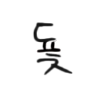

In [16]:
images[0]

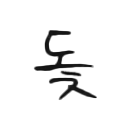

In [17]:
Image.open(inpaint_path)

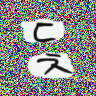

In [37]:
imagize(model.noise_list[0])[0]

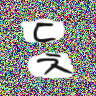

In [38]:
imagize(model.x_t_list[0])[0]

In [31]:
len(model.noise_list)

20